<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Fraud_Detection_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de detección temprana de anomalías y fraudes financieros multivariado con series temporales, usando Deep Learning (LSTM/Transformer) y métodos bayesianos para estimar riesgo dinámico en transacciones Mastercard a nivel global.

Detección en tiempo real de fraudes invisibles de bajo monto, usando anomalías multivariada

In [391]:
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [392]:
connection_db = sqlite3.connect("mastercard.db")

df_customers = pd.read_sql("SELECT * FROM customers", connection_db)
df_cards = pd.read_sql("SELECT * FROM cards", connection_db)
df_merchants = pd.read_sql("SELECT * FROM merchants", connection_db)
df_transactions = pd.read_sql("SELECT * FROM transactions", connection_db)
df_fraud_labels = pd.read_sql("SELECT * FROM fraud_labels", connection_db)

connection_db.close()

In [393]:
# @title
# data_for_predict_customers = df_customers.merge(df_cards, on="customer_id")[["customer_id","card_id","income", "age", "issue_year", "status"]]
# data_for_predict_customers = data_for_predict_customers.merge(df_transactions, on="card_id")[["customer_id","card_id","merchant_id","transaction_id","income", "age", "issue_year", "status","amount", "timestamp"]]
# data_for_predict_customers = data_for_predict_customers.merge(df_merchants, on="merchant_id")[["customer_id","card_id","merchant_id","transaction_id","income", "age", "issue_year", "status","amount", "timestamp","risk_score"]]
# data_for_predict_customers = data_for_predict_customers.merge(df_fraud_labels, on="transaction_id")[["customer_id","card_id","merchant_id","transaction_id","income", "age", "issue_year", "status","amount", "timestamp","risk_score","is_fraud"]]
# data_for_predict_customers["timestamp"] = pd.to_datetime(df_transactions["timestamp"]).dt.time
# data_for_predict_customers.rename(columns={"is_fraud":"target"}, inplace=True)
# data_for_predict_customers

In [394]:
customers_summary = pd.read_csv("/content/data_for_predict_customers.csv").groupby(
    ["customer_id",	"card_id", "income", "age", "issue_year", "status", "target"])[["merchant_id", "transaction_id", "amount", "timestamp",	"risk_score"]].count()

customers_summary # it's for know the customers data with frauds, useful after to do predicts

merchant_id  \
customer_id card_id income age issue_year status  target                
1           1389    59954  18  2017       Blocked 0                 6   
2           1585    70523  21  2016       Active  0                 3   
3           1762    49907  65  2019       Expired 0                 6   
4           76      76241  49  2016       Active  0                 3   
            79      76241  49  2015       Active  0                 2   
...                                                               ...   
1994        965     67012  33  2021       Blocked 0                 7   
1996        1573    71604  52  2021       Active  0                 4   
1997        567     61221  70  2021       Active  0                 4   
1998        940     39509  62  2017       Active  0                 6   
            1368    39509  62  2016       Active  0                 4   

                                                          transaction_id  \
customer_id card_id income age issue_year status  target                   
1           1389    59954  18  2017       Blocked 0                    6   
2           1585    70523  21  2016       Active  0                    3   
3           1762    49907  65  2019       Expired 0                    6   
4           76      76241  49  2016       Active  0                    3   
            79      76241  49  2015       Active  0                    2   
...                                                                  ...   
1994        965     67012  33  2021       Blocked 0                    7   
1996        1573    71604  52  2021       Active  0                    4   
1997        567     61221  70  2021       Active  0                    4   
1998        940     39509  62  2017       Active  0                    6   
            1368    39509  62  2016       Active  0                    4   

                                                          amount  timestamp  \
customer_id card_id income age issue_year status  target                      
1           1389    59954  18  2017       Blocked 0            6          6   
2           1585    70523  21  2016       Active  0            3          3   
3           1762    49907  65  2019       Expired 0            6          6   
4           76      76241  49  2016       Active  0            3          3   
            79      76241  49  2015       Active  0            2          2   
...                                                          ...        ...   
1994        965     67012  33  2021       Blocked 0            7          7   
1996        1573    71604  52  2021       Active  0            4          4   
1997        567     61221  70  2021       Active  0            4          4   
1998        940     39509  62  2017       Active  0            6          6   
            1368    39509  62  2016       Active  0            4          4   

                                                          risk_score  
customer_id card_id income age issue_year status  target              
1           1389    59954  18  2017       Blocked 0                6  
2           1585    70523  21  2016       Active  0                3  
3           1762    49907  65  2019       Expired 0                6  
4           76      76241  49  2016       Active  0                3  
            79      76241  49  2015       Active  0                2  
...                                                              ...  
1994        965     67012  33  2021       Blocked 0                7  
1996        1573    71604  52  2021       Active  0                4  
1997        567     61221  70  2021       Active  0                4  
1998        940     39509  62  2017       Active  0                6  
            1368    39509  62  2016       Active  0                4  

[2380 rows x 5 columns]

In [406]:
# @title
data_for_predict_customers = pd.read_csv("/content/data_for_predict_customers.csv")
status_new = pd.get_dummies(data_for_predict_customers["status"])
data_for_predict_customers = pd.concat([data_for_predict_customers, status_new], axis=1).drop("status", axis=1)
data_for_predict_customers[["Active","Blocked","Expired"]] = data_for_predict_customers[["Active","Blocked","Expired"]].astype(int)
data_for_predict_customers["timestamp"] = data_for_predict_customers["timestamp"].astype("datetime64[ns]")
data_for_predict_customers["timestamp"] = data_for_predict_customers["timestamp"].dt.hour
data_for_predict_customers["timestamp"] = data_for_predict_customers["timestamp"].astype(int)
data_for_predict_customers = data_for_predict_customers.rename(columns={"timestamp":"timestamp_hours"})
data_for_predict_customers.to_csv("clean_data_customers_for_predict.csv")

In [396]:
# @title
class fraud_analyzer():
  def __init__(self, * ,customers=None, transactions=None, cards=None, fraud_labels=None, merchants=None):
    self.customers = customers
    self.transactions = transactions
    self.cards = cards
    self.fraud_labels = fraud_labels
    self.merchants = merchants

  def Customers(self):
    fig, axes = plt.subplots(3,2, figsize=(16,8))
    fig.suptitle("Customers Analysis")

    # plot1
    axes[0,0].scatter(self.customers["age"], self.customers["income"], alpha=0.4)
    axes[0,0].set_xlabel("Age")
    axes[0,0].set_ylabel("Income")

    # plot2
    idcustomer_idtransaction_amount = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id", "transaction_id","amount"]]
    income_vs_amount = pd.merge(idcustomer_idtransaction_amount, self.customers, on="customer_id")[["income", "amount"]]

    axes[0,1].scatter(income_vs_amount["income"], income_vs_amount["amount"], alpha=0.2)
    axes[0,1].set_xlabel("Income")
    axes[0,1].set_ylabel("Transaction Amount")

    # plot3
    axes[1,0].hist(idcustomer_idtransaction_amount["customer_id"], bins=50)
    axes[1,0].set_xlabel("Customer ID")
    axes[1,0].set_ylabel("Transaction Frequency")

    # plot4
    data = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id","amount"]]
    data = data.groupby("customer_id").mean()

    axes[1,1].scatter(data.index, data["amount"], alpha=0.3)
    axes[1,1].set_xlabel("Customer ID")
    axes[1,1].set_ylabel("Average Transaction Amount")

    # plot5
    self.transactions["timestamp"] = pd.to_datetime(self.transactions["timestamp"])
    frequency_transaction_hour = self.transactions["timestamp"].dt.hour.sort_values()

    axes[2,0].hist(frequency_transaction_hour)
    axes[2,0].set_xlabel("Hour")
    axes[2,0].set_ylabel("Transaction Frequency")

    # plot6
    frequency_transaction_date = self.transactions["timestamp"].sort_values()
    frequency_transaction_date = self.transactions["timestamp"].dt.date
    frequency_transaction_date = pd.to_datetime(self.transactions["timestamp"])

    axes[2,1].hist(frequency_transaction_date, bins=80)
    axes[2,1].set_xlabel("Date")
    axes[2,1].set_ylabel("Transaction Frequency")

    fig.tight_layout()

  def transaction_customer_map(self):
    world_map = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

    countries = self.customers["country"].value_counts().reset_index().rename(columns={"country":"ISO_A2"})
    world_map = pd.merge(world_map, countries, on="ISO_A2")

    world_map.plot(column="count", cmap="OrRd", legend=True, color="lightblue", figsize=(20,8))

  def fraud_distribution(self):
    data = self.fraud_labels["is_fraud"].value_counts()
    data.plot(kind="bar")
    frauds_total = data.iloc[data.index == 1].item()
    fraud_porcent = (frauds_total * 100) / len(self.fraud_labels)

    print(data)
    print(f"\nFraud Porcent: {fraud_porcent}")

  class check_customers_cards():
    def __init__(self, cards):
      fraud_analyzer.cards

    def status():
      data = fraud_analyzer.cards["status"].value_counts().plot(kind="bar")
      plt.xlabel("")
      plt.ylabel("Number of Customers")

    def card_types():
      data = fraud_analyzer.cards["card_type"].value_counts().plot(kind="bar")
      plt.ylabel("Number of Customers")

    def seeker():

      while True:

        prompt = int(input("Enter the client id or 0 to exit: "))
        print()

        if prompt == 0:
          break

        elif prompt in fraud_analyzer.cards["customer_id"].unique():
          print(fraud_analyzer.cards[fraud_analyzer.cards["customer_id"] == prompt])
          print("\n\n")

        else:
          print("Customer not found")
          print("\n\n")

  class Merchants():
    def __init__(self, merchants):
      fraud_analyzer.merchants

    def sold_categories_merchants():
      fraud_analyzer.merchants["category"].value_counts().plot(kind="bar")

    def most_dangerous_merchants():
      fraud_analyzer.merchants["risk_score"].plot(kind="hist") # risk_score indicate how many historical frauds has every merchant
      plt.xlabel("Risk Score")
      plt.title("Distribution Risks Scores by Merchants")

      print("\nTop 10 most dangerous merchants:")
      print(fraud_analyzer.merchants.sort_values(by="risk_score", ascending=False).head(10))

fraud_analyzer = fraud_analyzer(customers=df_customers, transactions=df_transactions, cards=df_cards, fraud_labels=df_fraud_labels, merchants=df_merchants)

In [441]:
class backend_models():
  def __init__(self, data, model, precision, recall, f1score, AUC):
    self.data = data
    self.model = model
    self.precision = precision
    self.recall = recall
    self.f1score = f1score
    self.AUC = AUC

  def data_upload(self):
    self.data = pd.read_csv(self.data)
    self.X = self.data.drop(["customer_id", "card_id",	"merchant_id",	"transaction_id", "target"], axis=1)
    self.y = self.data["target"]

  def data_split(self):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42,stratify=y)

  def preprocessing(self):
    scaler = StandardScaler()
    self.X_train_scaled = scaler.fit_transform(self.X_train)
    self.X_test_scaled = scaler.transform(self.X_test)

  def model_train(self):
    model_trained = self.model.fit(self.X_train_scaled, self.y_train)
    self.model = model_trained

  def model_predict(self):
    self.prediction = self.model.predict(self.X_test_scaled)

  def model_evaluate(self):
    print(f"precision: {self.precision(self.y_test, self.prediction):.4f}")
    print(f"recall: {self.recall(self.y_test, self.prediction):.4f}")
    print(f"f1score: {self.f1score(self.y_test, self.prediction):.4f}")
    print(f"AUC: {self.AUC(self.y_test, self.prediction):.4f}")

  def ask_tuning(self):
    print("\n1. Yes\n2. No\n")
    choice = int(input("It's necessary tuning?: "))

    if choice == 1:
      params = dict(input("Enter de params like a dict: "))
      grid = GridSearchCV(self.model, params, cv=5)
      grid.fit(self.X_train_scaled, self.y_train)
      best_model = grid.best_estimator_
      print(f"best params: {grid.best_params_}\n")
      print(f"best score: {grid.best_score_}\n")

    else:
      pass

  def predictions(self):
    self.X = StandardScaler().fit_transform(self.X)
    prediction = self.model.predict(self.X)
    self.data["preds_reg_logistic"] = prediction
    data_preditcs_for_vis = self.data["preds_reg_logistic"].value_counts()
    data_preditcs_for_vis.plot(kind="bar")

    # ignore
    self.summary_customers = self.data.groupby(
        ["customer_id",	"card_id", "income",
         "age", "issue_year","target"])[["merchant_id", "transaction_id",
                                         "amount", "timestamp_hours",	"risk_score", "Active", "Blocked", "Expired", "preds_reg_logistic"]].count()

In [442]:
class models(backend_models):
  def __init__(self, *, data, model,precision, recall, f1score, AUC):
    super().__init__(data, model,precision, recall, f1score, AUC)

  def fraud_detect(self):
    self.data_upload()
    self.data_split()
    self.preprocessing()
    self.model_train()
    self.model_predict()
    self.model_evaluate()
    self.ask_tuning()

    return self.predictions()

  def comparision_trees_models():
    pass

  def neural_networks():
    pass

models = models(
    data="/content/clean_data_customers_for_predict.csv", model=LogisticRegression(class_weight='balanced', solver='liblinear'),
    precision=precision_score, recall=recall_score, f1score=f1_score, AUC=roc_auc_score)
# balanced because i have 10k labels and there is 219 frauds, that's very desbalanced and probably the model don't will predict good

precision: 0.0271
recall: 0.6136
f1score: 0.0518
AUC: 0.5586

1. Yes
2. No

It's necessary tuning?: 2


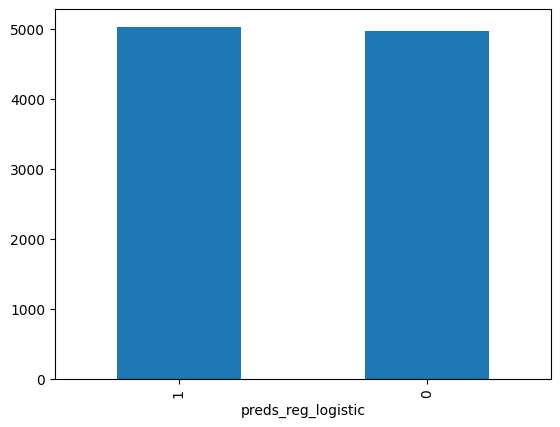

In [443]:
models.fraud_detect()

In [405]:
models.data[models.data["preds_reg_logistic"] == 1]

,customer_id,card_id,merchant_id,transaction_id,income,age,issue_year,amount,timestamp_hours,risk_score,target,Active,Blocked,Expired,preds_reg_logistic
1,1,1389,216,3929,59954,18,2017,51.21,3,0.38,0,0,1,0,1
2,1,1389,364,5301,59954,18,2017,107.27,8,0.34,0,0,1,0,1
4,1,1389,402,8161,59954,18,2017,302.43,4,0.13,0,0,1,0,1
5,1,1389,53,8859,59954,18,2017,93.32,6,0.15,0,0,1,0,1
6,2,1585,219,285,70523,21,2016,25.98,12,0.01,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,1998,940,82,1384,39509,62,2017,56.40,7,0.42,0,1,0,0,1
9992,1998,940,166,2230,39509,62,2017,36.27,0,0.51,0,1,0,0,1
9993,1998,940,426,4497,39509,62,2017,96.41,16,0.16,0,1,0,0,1
9996,1998,1368,303,1047,39509,62,2016,193.04,23,0.17,0,1,0,0,1


In [444]:
models.summary_customers

merchant_id  transaction_id  \
customer_id card_id income age issue_year target                                
1           1389    59954  18  2017       0                 6               6   
2           1585    70523  21  2016       0                 3               3   
3           1762    49907  65  2019       0                 6               6   
4           76      76241  49  2016       0                 3               3   
            79      76241  49  2015       0                 2               2   
...                                                       ...             ...   
1994        965     67012  33  2021       0                 7               7   
1996        1573    71604  52  2021       0                 4               4   
1997        567     61221  70  2021       0                 4               4   
1998        940     39509  62  2017       0                 6               6   
            1368    39509  62  2016       0                 4               4   

                                                  amount  timestamp_hours  \
customer_id card_id income age issue_year target                            
1           1389    59954  18  2017       0            6                6   
2           1585    70523  21  2016       0            3                3   
3           1762    49907  65  2019       0            6                6   
4           76      76241  49  2016       0            3                3   
            79      76241  49  2015       0            2                2   
...                                                  ...              ...   
1994        965     67012  33  2021       0            7                7   
1996        1573    71604  52  2021       0            4                4   
1997        567     61221  70  2021       0            4                4   
1998        940     39509  62  2017       0            6                6   
            1368    39509  62  2016       0            4                4   

                                                  risk_score  Active  Blocked  \
customer_id card_id income age issue_year target                                
1           1389    59954  18  2017       0                6       6        6   
2           1585    70523  21  2016       0                3       3        3   
3           1762    49907  65  2019       0                6       6        6   
4           76      76241  49  2016       0                3       3        3   
            79      76241  49  2015       0                2       2        2   
...                                                      ...     ...      ...   
1994        965     67012  33  2021       0                7       7        7   
1996        1573    71604  52  2021       0                4       4        4   
1997        567     61221  70  2021       0                4       4        4   
1998        940     39509  62  2017       0                6       6        6   
            1368    39509  62  2016       0                4       4        4   

                                                  Expired  preds_reg_logistic  
customer_id card_id income age issue_year target                               
1           1389    59954  18  2017       0             6                   6  
2           1585    70523  21  2016       0             3                   3  
3           1762    49907  65  2019       0             6                   6  
4           76      76241  49  2016       0             3                   3  
            79      76241  49  2015       0             2                   2  
...                                                   ...                 ...  
1994        965     67012  33  2021       0             7                   7  
1996        1573    71604  52  2021       0             4                   4  
1997        567     61221  70  2021       0             4                   4  
1998        940     39509  62  2017       0             6   